In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import string
import random
from tqdm.auto import tqdm
import torch
import transformers
from transformers import GPTNeoForCausalLM, GPT2Tokenizer
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from transformers import AdamW, get_cosine_schedule_with_warmup
from transformers import pipeline, set_seed

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
set_seed(42)

In [ ]:
data = pd.read_csv("/kaggle/input/summary-final-context/Summary_Final_context.csv")

In [ ]:
data.head(3)

,Pros,Cons,base msrp,Full Name,GPT-2 Summarization,horsepower,engine_type,Torque,Torque_RPM,drive_type,transmission,width,Length,Height,Context,final_context
0,"['Unmatched off-road capability, overflowing w...","['Soft top is fun, but still a pain in the $%!...",not available,jeep wrangler 1998,Jeep has improved off-road capability by incre...,120,Inline 4,140 lb-ft,"3,500",four wheel drive,5-speedmanual,66.7,147.7 in.,69.6 in.,The jeep wrangler 1998 is a vehicle with a Inl...,The jeep wrangler 1998 is a vehicle with a Inl...
1,"['Powerful engine lineup, well mannered on pav...","[""Cargo capacity isn't much more than what man...","$27,795",toyota 4runner 2005,The base V6 now comes with a five-speed automa...,245,V6,282 lb-ft,"3,800",rear wheel drive,5-speedautomatic,73.8,189.0 in.,68.5 in.,The toyota 4runner 2005 is a vehicle with a V6...,The toyota 4runner 2005 is a vehicle with a V6...
2,"['Silky V8, Toyota build quality, less-than-fu...",['Lacks wide range of choice offered by domest...,"$15,605",toyota tundra 2002,"SR5 models have new 16-inch wheels, and a limi...",190,V6,220 lb-ft,"3,600",rear wheel drive,5-speedmanual,75.2,217.5 in.,70.5 in.,The toyota tundra 2002 is a vehicle with a V6 ...,The toyota tundra 2002 is a vehicle with a V6 ...


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3141 entries, 0 to 3140
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Pros                 3141 non-null   object 
 1   Cons                 3141 non-null   object 
 2   base msrp            3141 non-null   object 
 3   Full Name            3141 non-null   object 
 4   GPT-2 Summarization  3141 non-null   object 
 5   horsepower           3141 non-null   int64  
 6   engine_type          3141 non-null   object 
 7   Torque               3141 non-null   object 
 8   Torque_RPM           3141 non-null   object 
 9   drive_type           3141 non-null   object 
 10  transmission         3141 non-null   object 
 11  width                3094 non-null   float64
 12  Length               3141 non-null   object 
 13  Height               3141 non-null   object 
 14  Context              3141 non-null   object 
 15  final_context        3141 non-null   o

In [ ]:
data= data.drop(columns=['Pros','Cons','horsepower','engine_type','Torque','Torque_RPM','drive_type','transmission','width','Length','Height'])

In [ ]:
prompts = []
targets = []
li = []
for index, row in data.iterrows():
    #remove \n and replace with space
    carName = str(row['Full Name']).replace('\n', ' ')
    #engine = str(row['engine']).replace('\n', ' ')
    #drivetrain = str(row['drivetrain']).replace('\n', ' ')
    #dimensions = str(row['dimensions']).replace('\n', ' ')
    description = str(row['final_context']).replace('\n', ' ')
    #prompt = 'Car: ' + carName + " "+ str(row['year']) + '\nEngine: ' + engine + '\nDrivetrain: ' + drivetrain + '\nDimensions: ' + dimensions + '\nDescription: '
    prompt = 'Car: ' + carName+'\nDescription: '
    target = description
    targets.append(target)
    prompts.append(prompt)
    li.append(prompt + ' ' + target)
    
data['prompt_target'] = li

In [ ]:
data['prompt_target']

0       Car: jeep wrangler 1998\nDescription:  The jee...
1       Car: toyota 4runner 2005\nDescription:  The to...
2       Car: toyota tundra 2002\nDescription:  The toy...
3       Car: toyota tacoma 1998\nDescription:  The toy...
4       Car: ford ranger 1990\nDescription:  The ford ...
                              ...                        
3136    Car: jeep renegade 2023\nDescription:  The jee...
3137    Car: bmw alpina-b7 2022\nDescription:  The bmw...
3138    Car: chevrolet colorado 2022\nDescription:  Th...
3139    Car: bmw 4-series 2023\nDescription:  The bmw ...
3140    Car: ford f-250-super-duty 2022\nDescription: ...
Name: prompt_target, Length: 3141, dtype: object

In [ ]:
print(li[0])

Car: jeep wrangler 1998
Description:  The jeep wrangler 1998 is a vehicle with a Inline 4 engine that delivers 120 horsepower and 140 lb-ft torque at 3,500. It has four wheel drive  and a 5-speedmanual. The car's dimensions are 147.7 in. in length, 69.6 in. in height, and 66.7 in width . Additionally, the base MSRP of this car is not available.  Now an in depth review of the jeep wrangler 1998:  Jeep has improved off-road capability by increasing the axle ratio offered with the 4.0-liter engine and revising the torsion bar for better steering. Optional this year on the 1998 Jeep Wrangler are a tilting driver seat, automatic speed control, a combination CD/cassette stereo, a new Smart Key Immobilizer theft-deterrent system and two new colors. We were a little concerned last year when we heard that Jeep was giving its bad-boy mud-machine  an overhaul. Luckily, the Wrangler hasn't received the leather interior, cellular phone makeover that has recently emasculated so much of the sport-uti

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

tokenized_data = data['prompt_target'].apply((lambda x: tokenizer.encode(x, max_length=1024,truncation=True)))

In [ ]:
# Define padding function
def pad_sequence(seq, max_len):
    seq_len = len(seq)
    if seq_len < max_len:
        seq = seq + [0] * (max_len - seq_len)
    elif seq_len > max_len:
        seq = seq[:max_len]
    return seq


In [ ]:
# Pad sequences
max_len = 1024
padded_data = [pad_sequence(seq, max_len) for seq in tokenized_data.values]
# Convert integers to strings and pad with spaces
padded_strings = [[' ' + chr(i) for i in seq] for seq in padded_data]
padded_strings = [[s[1:] for s in seq] for seq in padded_strings]
padded_strings = [pad_sequence(seq, max_len) for seq in padded_strings]
# Vectorize padded data
vectorized_data = np.vectorize(lambda x: ord(x))(padded_strings)

In [ ]:
# Flatten padded_data
padded_data = np.array([np.ravel(x) for x in padded_data]).astype(np.int64)

# Create attention masks
attention_masks = np.where(padded_data != 0, 1, 0)

In [ ]:
!conda install -y gdown

Retrieving notices: ...working... done

# >>>>>>>>>>>>>>>>>>>>>> ERROR REPORT <<<<<<<<<<<<<<<<<<<<<<

    Traceback (most recent call last):
      File "/opt/conda/lib/python3.10/site-packages/conda/gateways/repodata/__init__.py", line 161, in conda_http_errors
        yield
      File "/opt/conda/lib/python3.10/site-packages/conda/gateways/repodata/__init__.py", line 127, in repodata
        response.raise_for_status()
      File "/opt/conda/lib/python3.10/site-packages/requests/models.py", line 1021, in raise_for_status
        raise HTTPError(http_error_msg, response=self)
    requests.exceptions.HTTPError: 404 Client Error: Not Found for url: https://conda.anaconda.org/rapidsai/linux-64/current_repodata.json
    
    During handling of the above exception, another exception occurred:
    
    Traceback (most recent call last):
      File "/opt/conda/lib/python3.10/site-packages/requests/models.py", line 971, in json
        return complexjson.loads(self.text, **kwargs)
      File "

In [ ]:
!pip install gdown

In [ ]:
#https://drive.google.com/file/d/16fTX3RS3mF2ayn9YYWoNJBrfg6Cr8kpk/view?usp=share_link
#https://drive.google.com/file/d/<----16fTX3RS3mF2ayn9YYWoNJBrfg6Cr8kpk---->/view?usp=share_link

#https://drive.google.com/file/d/1ivZc4FbVM4eNmP6q6MwkD7m4w_pkHRzX/view?usp=share_link

#https://drive.google.com/file/d/1frAAjAF7Mp5Jl6o1YkZrcBsAJosGumrH/view?usp=share_link

#https://drive.google.com/file/d/1UM9mD4At8hB0alX6TuQVXXkxYb2M9I2g/view?usp=sharing

# https://drive.google.com/file/d/1ivZc4FbVM4eNmP6q6MwkD7m4w_pkHRzX/view?usp=share_link

In [ ]:
!gdown --id 1ivZc4FbVM4eNmP6q6MwkD7m4w_pkHRzX #16fTX3RS3mF2ayn9YYWoNJBrfg6Cr8kpk 

/opt/conda/lib/python3.10/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1ivZc4FbVM4eNmP6q6MwkD7m4w_pkHRzX
From (redirected): https://drive.google.com/uc?id=1ivZc4FbVM4eNmP6q6MwkD7m4w_pkHRzX&confirm=t&uuid=e085b868-403e-4519-a63d-122586d38229
To: /kaggle/working/PreFineTune_engine_type_And_Drive_Type.zip
100%|█████████████████████████████████████████| 463M/463M [00:02<00:00, 181MB/s]


In [ ]:
# 

In [ ]:
! unzip "/kaggle/working/PreFineTune_engine_type_And_Drive_Type.zip" -d PreFineTune_engine_type_And_Drive_Type

Archive:  /kaggle/working/PreFineTune_engine_type_And_Drive_Type.zip
  inflating: PreFineTune_engine_type_And_Drive_Type/config.json  
  inflating: PreFineTune_engine_type_And_Drive_Type/pytorch_model.bin  


In [ ]:
from transformers import BitsAndBytesConfig

In [ ]:
!pip install bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 11.2 MB/s eta 0:00:0000:0100:01


In [ ]:
from neural_compressor.adaptor.torch_utils.smooth_quant import TorchSmoothQuant

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GPT2LMHeadModel.from_pretrained('/kaggle/working/PreFineTune_engine_type_And_Drive_Type')



Some weights of the model checkpoint at /kaggle/working/PreFineTune_engine_type_And_Drive_Type were not used when initializing GPT2LMHeadModel: ['score.weight']
- This IS expected if you are initializing GPT2LMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2LMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
for name, param in model.transformer.named_parameters():
    print(name)

wte.weight
wpe.weight
h.0.ln_1.weight
h.0.ln_1.bias
h.0.attn.c_attn.weight
h.0.attn.c_attn.bias
h.0.attn.c_proj.weight
h.0.attn.c_proj.bias
h.0.ln_2.weight
h.0.ln_2.bias
h.0.mlp.c_fc.weight
h.0.mlp.c_fc.bias
h.0.mlp.c_proj.weight
h.0.mlp.c_proj.bias
h.1.ln_1.weight
h.1.ln_1.bias
h.1.attn.c_attn.weight
h.1.attn.c_attn.bias
h.1.attn.c_proj.weight
h.1.attn.c_proj.bias
h.1.ln_2.weight
h.1.ln_2.bias
h.1.mlp.c_fc.weight
h.1.mlp.c_fc.bias
h.1.mlp.c_proj.weight
h.1.mlp.c_proj.bias
h.2.ln_1.weight
h.2.ln_1.bias
h.2.attn.c_attn.weight
h.2.attn.c_attn.bias
h.2.attn.c_proj.weight
h.2.attn.c_proj.bias
h.2.ln_2.weight
h.2.ln_2.bias
h.2.mlp.c_fc.weight
h.2.mlp.c_fc.bias
h.2.mlp.c_proj.weight
h.2.mlp.c_proj.bias
h.3.ln_1.weight
h.3.ln_1.bias
h.3.attn.c_attn.weight
h.3.attn.c_attn.bias
h.3.attn.c_proj.weight
h.3.attn.c_proj.bias
h.3.ln_2.weight
h.3.ln_2.bias
h.3.mlp.c_fc.weight
h.3.mlp.c_fc.bias
h.3.mlp.c_proj.weight
h.3.mlp.c_proj.bias
h.4.ln_1.weight
h.4.ln_1.bias
h.4.attn.c_attn.weight
h.4.attn.c_at

In [ ]:
!pip install torch-pruning # v1.1.6

In [ ]:
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)


In [ ]:
#print(model.transformer.h[1].ln_2.weight) # should have half of its entries pruned

tensor([0.2235, 0.2545, 0.2449, 0.2550, 0.2341, 0.3014, 0.2175, 0.0000, 0.2321,
        0.2754, 0.2309, 0.2290, 0.2291, 0.2470, 0.2099, 0.2526, 0.2411, 0.2429,
        0.2351, 0.2133, 0.2697, 0.2545, 0.2413, 0.2459, 0.2508, 0.2329, 0.2342,
        0.2305, 0.2388, 0.2311, 0.2354, 0.2110, 0.2453, 0.2454, 0.2466, 0.2230,
        0.2208, 0.2804, 0.0000, 0.2829, 0.2607, 0.2929, 0.2574, 0.2282, 0.2523,
        0.2381, 0.2435, 0.2817, 0.2218, 0.2484, 0.2185, 0.2734, 0.2334, 0.2449,
        0.2647, 0.2549, 0.2355, 0.2118, 0.2629, 0.2145, 0.2333, 0.2514, 0.2107,
        0.2113, 0.0000, 0.2545, 0.2452, 0.2501, 0.0000, 0.2506, 0.2409, 0.2202,
        0.2468, 0.2729, 0.3157, 0.2520, 0.2370, 0.0000, 0.2621, 0.2484, 0.2868,
        0.2782, 0.2548, 0.2522, 0.2267, 0.2473, 0.2506, 0.0000, 0.2366, 0.2226,
        0.2143, 0.2777, 0.0000, 0.2371, 0.2339, 0.2820, 0.2310, 0.2202, 0.2364,
        0.2191, 0.2548, 0.2357, 0.0000, 0.2512, 0.2307, 0.2320, 0.2245, 0.2767,
        0.2618, 0.2275, 0.2427, 0.2283, 

In [ ]:
import torch.nn.utils.prune as prune
def prunningModel(model, amount=0.5):  
    # Prune word embedding layer
    prune.random_unstructured(model.transformer.wte, name="weight", amount=amount)

    # Prune positional encoding layer
    prune.random_unstructured(model.transformer.wpe, name="weight", amount=amount)
    
    # Prune positional encoding layer
    prune.random_unstructured(model.transformer.ln_f, name="weight", amount=amount)
    
    # Prune transformer layers
    for i in range(len(model.transformer.h)):
        # Prune self-attention layer
        prune.random_unstructured(model.transformer.h[i].attn.c_attn, name="weight", amount=amount)
        prune.random_unstructured(model.transformer.h[i].attn.c_proj, name="weight", amount=amount)
        # Prune feedforward layer
        prune.random_unstructured(model.transformer.h[i].mlp.c_fc, name="weight", amount=amount)
        prune.random_unstructured(model.transformer.h[i].mlp.c_proj, name="weight", amount=amount)
        # Prune normalization layers
        prune.l1_unstructured(model.transformer.h[i].ln_1, name="weight", amount=amount)
        prune.l1_unstructured(model.transformer.h[i].ln_2, name="weight", amount=amount)
    return model

In [ ]:
model = prunningModel(model, 0.1)

In [ ]:
# model.num_parameters()

124439808

In [ ]:
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)


In [ ]:
from sklearn.model_selection import train_test_split

train_data, val_data, train_masks, val_masks = train_test_split(padded_data, attention_masks, test_size=0.1)

In [ ]:

train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_data), torch.tensor(train_masks))
val_dataset = torch.utils.data.TensorDataset(torch.tensor(val_data), torch.tensor(val_masks))

batch_size = 2
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

optimizer = AdamW(model.parameters(), lr=1e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*10)


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
train_losses = []
val_losses = []

In [ ]:
model.eval()
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [ ]:
epochs = 5

for epoch in tqdm(range(1, epochs+1)):
    model.train()
    total_loss = 0
    for batch in tqdm(train_dataloader):
        inputs, masks = (i.to(device) for i in batch)
        model.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=inputs)
        loss = outputs[0]
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
        scheduler.step()
    
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))
    train_losses.append(avg_train_loss)
    
  # Evaluate the model on the validation set
    model.eval()
    total_eval_loss = 0
    progress_bar = tqdm(val_dataloader, desc=f"Epoch {epoch}", leave=False)
    for batch in progress_bar:
        inputs, masks = (i.to(device) for i in batch)
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=inputs)
            loss = outputs[0]
            total_eval_loss += loss.item()
        progress_bar.set_postfix({'validation_loss': '{:.3f}'.format(loss.item())})
    
    avg_eval_loss = total_eval_loss / len(val_dataloader)
    val_losses.append(avg_eval_loss)
    print("Average validation loss: {}".format(avg_eval_loss))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1413 [00:00<?, ?it/s]

Average train loss: 2.4788603577222372


Epoch 1:   0%|          | 0/158 [00:00<?, ?it/s]

Average validation loss: 1.8425622852165489


  0%|          | 0/1413 [00:00<?, ?it/s]

Average train loss: 1.717796885473713


Epoch 2:   0%|          | 0/158 [00:00<?, ?it/s]

Average validation loss: 1.5263602124362052


  0%|          | 0/1413 [00:00<?, ?it/s]

Average train loss: 1.5029000242129338


Epoch 3:   0%|          | 0/158 [00:00<?, ?it/s]

Average validation loss: 1.3999575793365888


  0%|          | 0/1413 [00:00<?, ?it/s]

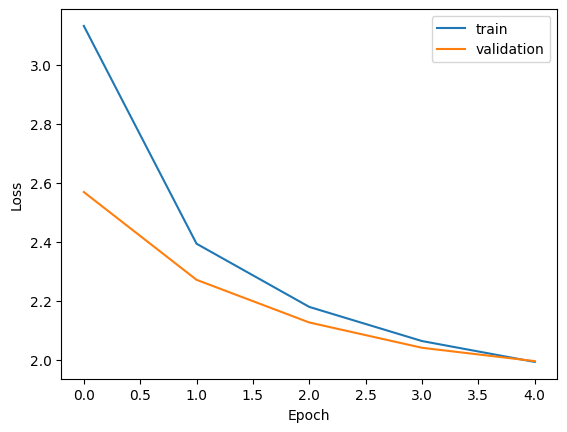

In [ ]:
# Plot the train and validation losses
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# PreFineTune_engine_type_And_Drive_Type

In [ ]:
model.save_pretrained('FineTune_gpt2_engine_type_And_Drive_Type_prunned_10')

In [ ]:
import shutil
shutil.make_archive("FineTune_gpt2_engine_type_And_Drive_Type_prunned_10", 'zip', "/kaggle/working/FineTune_gpt2_engine_type_And_Drive_Type_prunned_10")

'/kaggle/working/FineTune_gpt2_engine_type_And_Drive_Type_prunned_50.zip'

In [ ]:
%cd /kaggle/working

/kaggle/working


In [ ]:
from IPython.display import FileLink
FileLink(r'FineTune_gpt2_engine_type_And_Drive_Type_prunned_50.zip')

/kaggle/working/FineTune_gpt2_engine_type_And_Drive_Type_prunned_50.zip